In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gower
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from pandas.api.types import CategoricalDtype
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

Reading the csv-file

In [2]:
df = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\3. Semester\Machine Learning Unsupervised\mental-heath-in-tech-2016_20161114.csv")

Saving original columns

In [3]:
df_original_columns = df.columns

Renaming columns

In [4]:
renamed_columns = ['freelance', 'no_of_employees', 'tech_employer', 'tech_role_employer', 'mental_benefits_employer',
                  'mental_options_awareness_employer', 'mental_debate_', 'employer_mental_offers', 
                   'mental_anonymity_protected_employer','mental_leave_from_employer', 'mental_discussion_neg_consequence', 
                   'physical_discussion_neg_consequence_employer', 'mental_peer_discussion',
                   'mental_supervisor_discussion', 'mental_serious_employer', 
                   'mental_coworker_discussion_neg_impact_observed', 'mental_med_coverage', 'mental_local_online_offers',
                  'mental_diagnose_reveal', 'mental_diagnose_reveal_neg_impact', 'mental_diagnose_peer_reveal', 
                   'mental_diagnose_peer_reveal_neg_impact','mental_productivity_impact', 
                   'mental_productivity_percentage', 'prev_employers', 'prev_employer_mental_benefits', 
                   'prev_employer_mental_benefits_awareness','prev_employer_mental_discussion', 
                   'prev_employer_mental_offers', 'prev_employer_mental_anonymity', 
                   'prev_employer_mental_discussion_neg_impact', 
                   'prev_employer_physical_discussion_neg_impact',
                  'prev_employer_peers_willing_mental_discussion', 'prev_employer_mental_supervisor_discussion', 
                   'prev_employer_mental_serious', 'prev_employer_mental_peer_neg_impact_observed',
                  'potential_employer_physical_interview', 'why/why_not_physical', 'potential_employer_mental_interview', 'why/why_not_mental', 
                   'mental_neg_consequnce_career', 'mental_neg_depiction_peers',
                  'mental_reveal_private', 'all_emp_mental_neg_response_exp', 
                   'all_empl_mental_neg_response_exper_others', 'mental_family_history',
                  'mental_disorder_past', 'mental_disorder_current', 'yes_diagnosis_not_medical', 'maybe_diagnosis_own_believe', 
                   'mental_disorder_medical_diagnosed','yes_disorder_diagnosed_by_medical', 'mental_medical_treatment_ever', 
                   'mental_treatment_interfere_work', 'mental_no_treatment_interfere_work','age', 'gender', 'country_live_in', 
                   'live_in_us_territory', 'country_work_in', 'us_territory_work', 'work_position', 'work_remote']

Creating a list, with information about the data.

In [5]:
isna_list = df.isna().sum().to_list()
list_categories = []
v = 1
for x, y, z, a in zip(df_original_columns, renamed_columns, df, isna_list):
    print(str(v), x, "|", y, "|", "possible answers:", str(df[z].unique()), "|", "number of isna in the the feature:", a)
      

    v += 1

1 Are you self-employed? | freelance | possible answers: [0 1] | number of isna in the the feature: 0
2 How many employees does your company or organization have? | no_of_employees | possible answers: ['26-100' '6-25' nan 'More than 1000' '100-500' '500-1000' '1-5'] | number of isna in the the feature: 287
3 Is your employer primarily a tech company/organization? | tech_employer | possible answers: [ 1. nan  0.] | number of isna in the the feature: 287
4 Is your primary role within your company related to tech/IT? | tech_role_employer | possible answers: [nan  1.  0.] | number of isna in the the feature: 1170
5 Does your employer provide mental health benefits as part of healthcare coverage? | mental_benefits_employer | possible answers: ['Not eligible for coverage / N/A' 'No' nan 'Yes' "I don't know"] | number of isna in the the feature: 287
6 Do you know the options for mental health care available under your employer-provided coverage? | mental_options_awareness_employer | possible 

Renaming the columns in the dataframe to be worked with.

In [6]:
df.columns = renamed_columns

In [7]:
#Figuring out which top countries ammount to 95 Percent of the dataset.

for x in df["country_work_in"].value_counts().cumsum():
    if x/1433 > 0.95:
        print(x)
        break
        
df_top_95_countries = df["country_work_in"].value_counts().cumsum()[:17].to_frame().reset_index()
df_top_95_countries_full = df.loc[df["country_work_in"].isin(df_top_95_countries["index"].to_list())]

1364


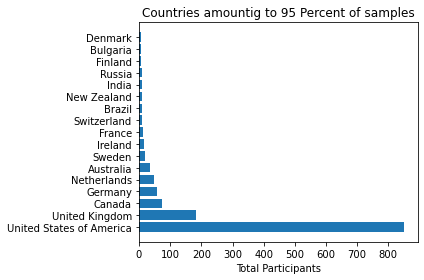

In [8]:
df_top_95_countries_full_ordered =df_top_95_countries_full["country_work_in"].value_counts().to_frame().reset_index()
y_pos = np.arange(len(df_top_95_countries_full_ordered["index"]))


plt.barh(y_pos, df_top_95_countries_full_ordered["country_work_in"], alpha=1)
plt.yticks(y_pos, df_top_95_countries_full_ordered["index"])
plt.xlabel('Total Participants')
plt.title('Countries amountig to 95 Percent of samples')

plt.tight_layout()
plt.show()

Getting all the columns in the same form. Hence I will be using gower-distance, categorial and ordinal data can be stored as words. 
Furthermore changing the object type to category type, so that I can create ordinal data structures.

In [9]:
df["mental_medical_treatment_ever"].replace((1, 0), ('Yes', 'No'), inplace=True)
df["prev_employers"].replace((1, 0), ('Yes', 'No'), inplace=True)
df["freelance"].replace((1, 0), ('Yes', 'No'), inplace=True)

for x in df:
    if df[x].dtype == "object":
        df[x] = df[x].astype('category')


In [10]:
# creating ordinal features where it makes sense.
cat_type = CategoricalDtype(categories=['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], ordered=True)
df["no_of_employees"] = df["no_of_employees"].astype(cat_type)
cat_type = CategoricalDtype(categories=['1-25%', '26-50%','51-75%', '76-100%'], ordered=True)
df["mental_productivity_percentage"] = df["mental_productivity_percentage"].astype(cat_type)
cat_type = CategoricalDtype(categories=['None did', 'Some did', 'Yes, they all did'], ordered=True)
df["prev_employer_mental_offers"] = df["prev_employer_mental_offers"].astype(cat_type)
cat_type = CategoricalDtype(categories=['None of them', 'Some of them', 'Yes, all of them'], ordered=True)
df["prev_employer_physical_discussion_neg_impact"] = df["prev_employer_physical_discussion_neg_impact"].astype(cat_type)
cat_type = CategoricalDtype(categories=['No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'], ordered=True)
df["prev_employer_peers_willing_mental_discussion"] = df["prev_employer_peers_willing_mental_discussion"].astype(cat_type)
cat_type = CategoricalDtype(categories=['None of them', 'Some of them', 'Yes, all of them'], ordered=True)
df["prev_employer_mental_peer_neg_impact_observed"] = df["prev_employer_mental_peer_neg_impact_observed"].astype(cat_type)
cat_type = CategoricalDtype(categories=['Never', 'Sometimes', 'Always'], ordered=True)
df["work_remote"] = df["work_remote"].astype(cat_type)


Visualizing missing values

<AxesSubplot:>

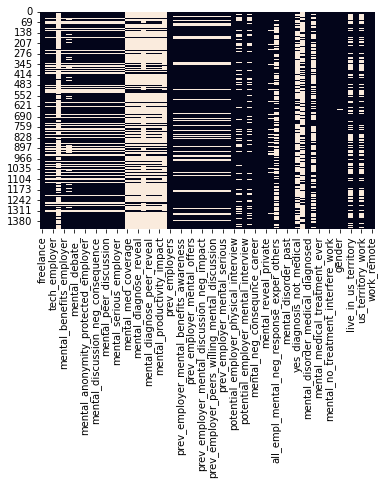

In [11]:
sns.heatmap(df.isnull(), cbar=False)

Checking what features have too many different values and might therefore be deleted or processed otherwise

In [12]:
data_cardinality = []
data_all = []

for x in df.columns:
    if len(df[x].value_counts(dropna=False)) > 10:

        data_cardinality.append(x)
        data_cardinality.append(len(df[x].value_counts(dropna=False)))
        data2 = [data_cardinality]
        data_all.extend(data2)
            
        data_cardinality = []
        data2 = []  

df_high_cardinality = pd.DataFrame(data_all, columns=["df_name", 'cardinality']) 
df_high_cardinality

,df_name,cardinality
0,why/why_not_physical,1086
1,why/why_not_mental,1081
2,yes_diagnosis_not_medical,129
3,maybe_diagnosis_own_believe,100
4,yes_disorder_diagnosed_by_medical,117
5,age,53
6,gender,71
7,country_live_in,53
8,live_in_us_territory,48
9,country_work_in,53


Figuring out if the features maybe_diagnosis_own_believe', and 'yes_diagnosis_not_medical' are associated with 'yes_disorder_diagnosed_by_medical'
If so, they could be deleted.

In [13]:
data = pd.crosstab(df['maybe_diagnosis_own_believe'], df['yes_disorder_diagnosed_by_medical'], margins = False)

stat, p, dof, expected = stats.chi2_contingency(data)

alpha = 0.05

print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated')
else:
    print('Variables are not associated')

Significance=0.050, p=0.000
Variables are associated


In [14]:
data = pd.crosstab(df['yes_diagnosis_not_medical'], df['yes_disorder_diagnosed_by_medical'], margins = False) 

stat, p, dof, expected = stats.chi2_contingency(data)
alpha = 0.05

print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated')
else:
    print('Variables are not associated')

Significance=0.050, p=0.000
Variables are associated


Checking if df['country_work_in'] and df['country_live_in'] are dependent on each other, so that one could be deleted.

In [15]:
data = pd.crosstab(df['country_work_in'], df['country_live_in'], margins = False)

contingency = pd.crosstab(df['country_work_in'], df['country_live_in'])
stat, p, dof, expected = stats.chi2_contingency(contingency)

alpha = 0.05

print('Significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Variables are associated')
else:
    print('Variables are not associated')

Significance=0.050, p=0.000
Variables are associated


In [16]:
df_ohe_reverse_colum_diagnosis = df["yes_diagnosis_not_medical"].copy()
df_ohe_reverse_colum_work_position = df["work_position"].copy()


# Everything above cardinality of 10 is considered to be deleted. E.g. [why/why_not  why/why_not2]. Features that contain basically the same information like yes_diagnosis_not_medical, maybe_diagnosis_own_believe , 
# yes:condition diagnosed are deleted but one (yes_disorder_diagnosed_by_medical) is kept and will be processed further. Reason is, that it is the mental illness diagnosed by a doctor. country_live_in is dropped, 
# but country work is kept. ´live_in_us_territory  is deleted hence it contains information only for some rows of the dataset. work_position becomes vectorized like yes_disorder_diagnosed_by_medical 
# and is therefore kept.

df.drop(columns=["why/why_not_physical", "why/why_not_mental", "live_in_us_territory", "country_live_in", "us_territory_work", 'yes_diagnosis_not_medical', 'maybe_diagnosis_own_believe'], inplace=True)


Cleaning up the age column

In [17]:
mean_age =df["age"].mean()
df.loc[df['age'] <= 18, 'age'] = mean_age
df.loc[df['age'] >= 75, 'age'] = mean_age
mean_corrected = df["age"].mean()
df.loc[df['age'] <= 18, 'age'] = mean_corrected
df.loc[df['age'] >= 75, 'age'] = mean_corrected

Cleaning up the gender field

In [18]:
df['gender'] = df['gender'].str.lower()
df["gender"] = df["gender"].str.strip()

gender_male_freeform = ['cis male','maile', 'Make', 'Mal', 'Cis Man','cis man', 'man', 'gender is male', 'Male', 'male', 'ostensibly male, unsure what that really means', 'male.', 'M', 'Malr', 'malr', 
'Cis Male', 'm', 'mail','male (cis)', 'msle', 'Mail', 'male ', 'dude']

gender_female_freeform = ['cis female', 'cis-female/femme', 'i identify as female.', 'F', 'Woman', 'female (props for making this a freeform field, though)', 'female assigned at birth', 
'female', 'woman', 'femail', 'Female', 'Femake', 'Female (cis)', 'cis-woman', 'cisgender female', 'female/woman', 'f', 'female-bodied; no feelings about gender', 'fm', ' female', 'cis female']

gender_undefined_freeform = (df["gender"].value_counts().index[2:].to_list())

df["gender"] = df["gender"].replace(gender_male_freeform, 'male')
df["gender"] = df["gender"].replace(gender_female_freeform, 'female')
df["gender"] = df["gender"].replace(gender_undefined_freeform, 'other')
df["gender"] = df["gender"].astype('category')

Cleaning up and Bag-of-Work-Vectorizing the Work_Position_Field

In [19]:
df['work_position'] = df['work_position'].str.lower()
df["work_position"] = df["work_position"].str.strip()

work_list_to_be_set = df["work_position"].value_counts().index.to_list()

#Creating a set of unique work descriptions and cleansing it befor vectorizing.
work_list_split = [item.split('|') for item in work_list_to_be_set]

work_list_flat = [item for l in work_list_split for item in l]
set_of_work_list_flat = set(work_list_flat)

set_of_work_list_flat = list(set_of_work_list_flat)

set_of_work_list_flat = [i.replace("-", "") for i in set_of_work_list_flat]
set_of_work_list_flat = [i.replace("/", "") for i in set_of_work_list_flat]
set_of_work_list_flat = [i.replace(" ", "") for i in set_of_work_list_flat]

# cleaning the work list to vectorize it with the set of work descriptions
work_list_full = df["work_position"].to_list()
work_list_full = [i.replace("-", "") for i in work_list_full]
work_list_full = [i.replace("/", "") for i in work_list_full]
work_list_full = [i.replace(" ", "") for i in work_list_full]
work_list_full = [i.replace("|", ", ") for i in work_list_full]

# the actual vectorizing
corpus = work_list_full
cv = CountVectorizer(vocabulary=set_of_work_list_flat, lowercase=True)
X = cv.fit_transform(corpus)
array_worklist = X.toarray()

df_work_list = pd.DataFrame(array_worklist)
df_work_list.columns = set_of_work_list_flat


Cleaning up and Bag-Of-Word-Vectorizing the yes_disorder_diagnosed_by_medical field.

In [20]:
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.lower()
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.strip()
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\s+\(.*\)","")
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\s+\-","")
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\"", "")
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\,", "")
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r'posttraumatic stress disourder', 'post-traumatic stress disorder')
df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r'depression', 'mood disorder')
df['yes_disorder_diagnosed_by_medical'].fillna("healthy", inplace=True)

asperger_list = ['asperger spectrum disorder', 'autism spectrum disorder', 'asperger syndrome', 'aspergers', 'autism while not a mental illness still greatly affects how i handle anxiety', 'autism'] 
adhd_list = ['attention deficit disorder','attention deficit hyperactivity disorder', 'add', 'mcd', ]
personality_disorder = ['pdd-nos \(see above\)', 'pdd-nos']
gender_list = ['gender dysphoria','gender identity disorder','intimate disorder',]
mood_disorder_list = ["depression", "seasonal affective disorder"]

df = df.replace({'yes_disorder_diagnosed_by_medical': asperger_list}, {'yes_disorder_diagnosed_by_medical': 'spectrumdisorder'}, regex=True)
df = df.replace({'yes_disorder_diagnosed_by_medical': adhd_list}, {'yes_disorder_diagnosed_by_medical': 'adhd'}, regex=True)
df = df.replace({'yes_disorder_diagnosed_by_medical': personality_disorder}, {'yes_disorder_diagnosed_by_medical': 'personality disorder'}, regex=True)
df = df.replace({'yes_disorder_diagnosed_by_medical': gender_list}, {'yes_disorder_diagnosed_by_medical': 'gender disorder'}, regex=True)
df = df.replace({'yes_disorder_diagnosed_by_medical': mood_disorder_list}, {'yes_disorder_diagnosed_by_medical': 'mood disorder'}, regex=True)


#Creating a set of unique condition descriptions and cleansing it befor vectorizing.
condition_list_to_be_set = df["yes_disorder_diagnosed_by_medical"].value_counts().index.to_list()
condition_list_split = [item.split('|') for item in condition_list_to_be_set]

condition_list_flat = [item for l in condition_list_split for item in l]
set_of_condition_list_flat = set(condition_list_flat)
set_of_condition_list_flat_check = set(condition_list_flat)

set_of_condition_list_flat = list(set_of_condition_list_flat)

set_of_condition_list_flat = [i.replace("-", "") for i in set_of_condition_list_flat]
set_of_condition_list_flat = [i.replace("/", "") for i in set_of_condition_list_flat]
set_of_condition_list_flat = [i.replace(" ", "") for i in set_of_condition_list_flat]


# cleaning the condition list to vectorize it with the set of condition descriptions
condition_list_full = df["yes_disorder_diagnosed_by_medical"].to_list()

condition_list_full = [str(i).replace("-", "") for i in condition_list_full]
condition_list_full = [str(i).replace("/", "") for i in condition_list_full]
condition_list_full = [str(i).replace(" ", "") for i in condition_list_full]
condition_list_full = [str(i).replace("|", ", ") for i in condition_list_full]

corpus = condition_list_full
cv = CountVectorizer(vocabulary=set_of_condition_list_flat, lowercase=True)
X = cv.fit_transform(corpus)

array_condition_list = X.toarray()

df_condition_list = pd.DataFrame(array_condition_list)
df_condition_list.columns = set_of_condition_list_flat



C:\Users\Max_G\AppData\Local\Temp/ipykernel_27416/1391968876.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\s+\(.*\)","")
C:\Users\Max_G\AppData\Local\Temp/ipykernel_27416/1391968876.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\s+\-","")
C:\Users\Max_G\AppData\Local\Temp/ipykernel_27416/1391968876.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes_disorder_diagnosed_by_medical'] = df['yes_disorder_diagnosed_by_medical'].str.replace(r"\"", "")
C:\Users\Max_G\AppData\Local\Temp/ipykernel_27416/1391968876.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['yes_disorder_diagnose

Splitting up the dataframes in different branches to see how column or row dropping impacts the final silhouette score.

In [21]:
#Two df to be created: Dropping rare countries or keeping it.


dataframes_dict = {}
df_all_countries = df.copy()

dataframes_dict["all_countries"] = df_all_countries
print("original lenght", len(dataframes_dict["all_countries"]))

#Dropping rare countries
coutry_list = df["country_work_in"].value_counts().index[0:5].to_list()
df_no_rare_countries = df.loc[df['country_work_in'].isin(coutry_list)].copy()

dataframes_dict["df_no_rare_countries"] = df_no_rare_countries.copy()
print("lenght after country_work_in drop", len(dataframes_dict["df_no_rare_countries"]))

#deleting the not used df's to safe space.
df_no_rare_countries = pd.DataFrame()

original lenght 1433
lenght after country_work_in drop 1213


replacing NaNs I can identify meaningful with meaningful values.

In [22]:
# the idea is,that plenty of columns are missing values hence they are freelancer or its their first job. Therefore I will replace nans in these brach 
# of dataframes with meaningful variables.

name_list = ["all_countries_filled", "df_no_rare_countries_filled"]
transform_dict = {}

for x in dataframes_dict:
    transform_dict[x] = dataframes_dict[x].copy()

for x, y in zip(transform_dict, name_list):
    dataframes_dict[y] = transform_dict[x].copy()
    

# deleting the copy tool again to safe space    
transform_dict = {}

In [23]:
# substituting the nan values

for x in dataframes_dict:
    if x in name_list:
        list_values_self_employed =  dataframes_dict[x]["freelance"].value_counts().to_list()
        list_values_previous_companies = dataframes_dict[x]["prev_employers"].value_counts().to_list()

        df_transform = pd.DataFrame()
        df_transform = dataframes_dict[x].isna().sum().to_frame()
        df_transform.reset_index(inplace=True)
        df_transform.columns = ["column_names", "isnanumber"]

        list_of_self_employed = df_transform.loc[df_transform['isnanumber'] == list_values_self_employed[1], 'column_names'].to_list()
        print(f"The following colums conatining {list_values_self_employed[1]} nan values have been replacecd with freelance in {x}. \
        If they are self employed there answer in these columns is nan:\n", list_of_self_employed)


        for y in list_of_self_employed:
            dataframes_dict[x][y] = dataframes_dict[x][y].replace(np.nan, "freelance")

        list_of_previous_companies_columns = df_transform.loc[df_transform['isnanumber'] == list_values_previous_companies[1], 'column_names'].to_list()

        for y in list_of_previous_companies_columns:
             dataframes_dict[x][y] = dataframes_dict[x][y].replace(np.nan, "first_job")

        print(f"\n The following colums conatining {list_values_previous_companies[1]} nan values have been replacecd with first_job in {x}. If this is their \
        first job, their answer in these columns is nan:\n", list_of_previous_companies_columns)

    else:
        pass


The following colums conatining 287 nan values have been replacecd with freelance in all_countries_filled.         If they are self employed there answer in these columns is nan:
 ['no_of_employees', 'tech_employer', 'mental_benefits_employer', 'mental_debate_', 'employer_mental_offers', 'mental_anonymity_protected_employer', 'mental_leave_from_employer', 'mental_discussion_neg_consequence', 'physical_discussion_neg_consequence_employer', 'mental_peer_discussion', 'mental_supervisor_discussion', 'mental_serious_employer', 'mental_coworker_discussion_neg_impact_observed']

 The following colums conatining 169 nan values have been replacecd with first_job in all_countries_filled. If this is their         first job, their answer in these columns is nan:
 ['prev_employer_mental_benefits', 'prev_employer_mental_benefits_awareness', 'prev_employer_mental_discussion', 'prev_employer_mental_offers', 'prev_employer_mental_anonymity', 'prev_employer_mental_discussion_neg_impact', 'prev_employer_

Creating another branch, to see how that impacts the clustering

In [24]:
# this branch consists of the df with all countries but missing values are simply imputed. Its obviously a bad choice, but I want to see what it does.

dataframes_dict["all_countries_imputed"] = dataframes_dict["all_countries"].copy()

for x in dataframes_dict["all_countries_imputed"]:
    dataframes_dict["all_countries_imputed"][x].fillna(dataframes_dict["all_countries_imputed"][x].mode()[0], inplace = True)

Dropping the columns with nan values of more than 10 percent. Imputing columns which have NaN values between 0 and 10 percent.

In [25]:
for x in dataframes_dict:
    
    cols = dataframes_dict[x].columns[dataframes_dict[x].isna().mean()>0.1]
    print(f"The following collumn in {x}, containing more than 10% nan values, which couldn't be accounted for where dropped: {cols.to_list()}")
    dataframes_dict[x].drop(cols, axis=1, inplace=True)


    df_transformed = dataframes_dict[x].isna().mean().to_frame()
    df_transformed.reset_index(inplace=True)
    df_transformed.columns = ["column", "percentage"]
    df_transformed_list = df_transformed.query('0 < percentage <= 0.1')["column"].to_list()

    print(f"The following collums contain < 0 but <= 0.1 percentage of na values {df_transformed_list} and will be imputed with mode value")

    for y in df_transformed_list: 
        dataframes_dict[x][y].fillna(dataframes_dict[x][y].mode()[0], inplace = True)
    
#checking if no more nan are left.

    df_check = dataframes_dict[x].isna().sum().to_frame().reset_index()
    df_check.columns = ["column", "nan"] 
    if df_check["nan"].sum() == 0:
        print("No more nan values left")


The following collumn in all_countries, containing more than 10% nan values, which couldn't be accounted for where dropped: ['no_of_employees', 'tech_employer', 'tech_role_employer', 'mental_benefits_employer', 'mental_options_awareness_employer', 'mental_debate_', 'employer_mental_offers', 'mental_anonymity_protected_employer', 'mental_leave_from_employer', 'mental_discussion_neg_consequence', 'physical_discussion_neg_consequence_employer', 'mental_peer_discussion', 'mental_supervisor_discussion', 'mental_serious_employer', 'mental_coworker_discussion_neg_impact_observed', 'mental_med_coverage', 'mental_local_online_offers', 'mental_diagnose_reveal', 'mental_diagnose_reveal_neg_impact', 'mental_diagnose_peer_reveal', 'mental_diagnose_peer_reveal_neg_impact', 'mental_productivity_impact', 'mental_productivity_percentage', 'prev_employer_mental_benefits', 'prev_employer_mental_benefits_awareness', 'prev_employer_mental_discussion', 'prev_employer_mental_offers', 'prev_employer_mental_an

In [26]:
#dropping the "yes_disorder_diagnosed_by_medical", "work_position" columns since they are of too high cardinality.

df_ohe_prepare_for_reverse = dataframes_dict["all_countries"].copy()

for x in dataframes_dict:
    dataframes_dict[x]= dataframes_dict[x].drop(["yes_disorder_diagnosed_by_medical", "work_position"], axis=1)


# creating another dataframe for the hierarchical clustering
dataframes_dict["all_countries_hierarchical"] = dataframes_dict["all_countries"].copy()

Creating a dataframe, with one hot encoding.

In [27]:
# I have to drop the country work column for OHE hence gower canot work with so many different columns.

dataframes_dict["df_ohe_w/o_bow_features"] = dataframes_dict["all_countries"].copy()


column_list = []
for x in dataframes_dict["df_ohe_w/o_bow_features"]:
    if x == "age":
        pass
    else:
        column_list.append(x)

# creating to dataframes with OHE, with the BOW features.

dataframes_dict["df_ohe_w/o_bow_features"] = pd.get_dummies(dataframes_dict["df_ohe_w/o_bow_features"], prefix=column_list, columns=column_list)
dataframes_dict["df_ohe_with_bow_features"] = dataframes_dict["df_ohe_w/o_bow_features"].copy()
dataframes_dict["df_ohe_with_bow_features"] = pd.concat((dataframes_dict["df_ohe_with_bow_features"], df_work_list), axis=1)
dataframes_dict["df_ohe_with_bow_features"] = pd.concat((dataframes_dict["df_ohe_with_bow_features"], df_condition_list), axis=1)

#copying it for the pca.

df_ohe_pca_dict = {}
df_ohe_pca_dict["df_ohe_w/o_bow_features"] = dataframes_dict["df_ohe_w/o_bow_features"].copy()
df_ohe_pca_dict["df_ohe_with_bow_features"] = dataframes_dict["df_ohe_with_bow_features"].copy()

Creating a list to tell gower distance what columns contain categorial data (ordinal + nominal) and which contain numeric values.

In [28]:
cat_dict = {}
cat_list = []

for dataframe in dataframes_dict:
    for column in dataframes_dict[dataframe]:
        for column in dataframes_dict[dataframe].columns:
            if dataframes_dict[dataframe].columns.get_loc("age") == dataframes_dict[dataframe].columns.get_loc(column):
                cat_list.append(False)
            else:
                cat_list.append(True)
        cat_dict[dataframe] = cat_list
        cat_list = []

Calculating the gower matrix for all dataframes within the dictionary

In [29]:
for x in dataframes_dict:
    print(f"The following dataframes will have gower matrices created {x}")

gower_matrix_dict= {}
for df_name in dataframes_dict:
    gower_matrix_dict[df_name] = gower.gower_matrix(dataframes_dict[df_name], cat_features=cat_dict[df_name])

The following dataframes will have gower matrices created all_countries
The following dataframes will have gower matrices created df_no_rare_countries
The following dataframes will have gower matrices created all_countries_filled
The following dataframes will have gower matrices created df_no_rare_countries_filled
The following dataframes will have gower matrices created all_countries_imputed
The following dataframes will have gower matrices created all_countries_hierarchical
The following dataframes will have gower matrices created df_ohe_w/o_bow_features
The following dataframes will have gower matrices created df_ohe_with_bow_features


Calculationg optimal silhouete scores for DBSCAN. This will take while

In [30]:
#calculating the optimal parameters for the optimal silhouete score.

eps_list = []
for i in np.linspace(0.1, 0.3, num=29):
    eps_list.append(i.round(2))

min_sampe_list = [x for x in range(2, 11 , 1)]

data_all = []

for df_name in dataframes_dict:
    for eps_value in eps_list:
        data1 = []
        data2 = []
        for min_sample in min_sampe_list:
            dbscan_cluster = DBSCAN(eps=eps_value, 
                            min_samples=min_sample, 
                            metric="precomputed")

            dbscan_cluster.fit(gower_matrix_dict[df_name])
    
            dataframes_dict[df_name]["cluster"] = dbscan_cluster.labels_
            no_of_clusters = dataframes_dict[df_name]["cluster"].nunique()

            data1.append(df_name)
            data1.append(eps_value)
            data1.append(min_sample)
            score = np.nan
            try:
                score = metrics.silhouette_score(gower_matrix_dict[df_name], dbscan_cluster.labels_)
            except: ValueError
            data1.append(no_of_clusters)
            data1.append(score)
            
            
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []  

df_silhouette_score = pd.DataFrame(data_all, columns=["df_name", 'eps_value', 'min_sample', '# of clusters', 'score']) 

In [31]:
# creating a dictionary for all the silhouette_score dataframes by name of the coresponding dataframe.

df_silhouette_score_clustered = {}

for df_name in dataframes_dict:
    df_silhouette_score_clustered[df_name] = df_silhouette_score.loc[df_silhouette_score['df_name'] == df_name] 

In [32]:
#creating a dictionary conatining all the optimal values, so that dbscan can use them.

best_parameters_dict = {}

for x in df_silhouette_score_clustered:
    best_parameters_dict[x] = {}

for x in df_silhouette_score_clustered:
    best_parameters_dict[x]["best_eps_value"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][1]
    best_parameters_dict[x]["best_min_sample"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][2]
    best_parameters_dict[x]["no_of_clusters"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][3]
    best_parameters_dict[x]["silhouette_score"] = df_silhouette_score_clustered[x].loc[df_silhouette_score_clustered[x]['score'].idxmax()][4]


for x in df_silhouette_score_clustered:
    print(f"The dataframe {x}, has the following values")
    print("best_eps_value =", best_parameters_dict[x]["best_eps_value"])
    print("best_min_sample =",  best_parameters_dict[x]["best_min_sample"])
    print("no_of_clusters =", best_parameters_dict[x]["no_of_clusters"])
    print("silhouette_score =", best_parameters_dict[x]["silhouette_score"])

    



The dataframe all_countries, has the following values
best_eps_value = 0.19
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.17527513206005096
The dataframe df_no_rare_countries, has the following values
best_eps_value = 0.19
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.18796716630458832
The dataframe all_countries_filled, has the following values
best_eps_value = 0.2
best_min_sample = 9
no_of_clusters = 3
silhouette_score = 0.12741787731647491
The dataframe df_no_rare_countries_filled, has the following values
best_eps_value = 0.2
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.1444181352853775
The dataframe all_countries_imputed, has the following values
best_eps_value = 0.23
best_min_sample = 9
no_of_clusters = 2
silhouette_score = 0.07179472595453262
The dataframe all_countries_hierarchical, has the following values
best_eps_value = 0.19
best_min_sample = 8
no_of_clusters = 3
silhouette_score = 0.17527513206005096
The dataframe df_ohe_w/o_bow_f

In [33]:
for x in dataframes_dict:
    dataframes_dict[x].drop(columns="cluster", inplace=True)

The clustering in DBSCAN with the optimal values.

In [34]:
# the actual clustering  for all the dataframes with the optimal values.
dbscan_cluster_dict_best_fit = {}

for x in best_parameters_dict:
    dbscan_cluster_dict_best_fit[x] = DBSCAN(eps=best_parameters_dict[x]["best_eps_value"], 
                            min_samples=best_parameters_dict[x]["best_min_sample"], 
                            metric="precomputed")
    

for x in dbscan_cluster_dict_best_fit:
    dbscan_cluster_dict_best_fit[x].fit(gower_matrix_dict[x])
    dataframes_dict[x]["cluster"] = dbscan_cluster_dict_best_fit[x].labels_
    try:
        print(x, metrics.silhouette_score(gower_matrix_dict[x], dbscan_cluster_dict_best_fit[x].labels_))
    except: ValueError


# Tried to plot a silhouette score visualization. Yellowbrick unfortunately doesn’t work with dbscan.

all_countries 0.17527513
df_no_rare_countries 0.18796717
all_countries_filled 0.12741788
df_no_rare_countries_filled 0.14441814
all_countries_imputed 0.071794726
all_countries_hierarchical 0.17527513
df_ohe_w/o_bow_features 0.046530943
df_ohe_with_bow_features 0.20055597


Preparing a dictionary for EDA.

In [35]:
cluster_list = []

dataframes_dict["df_ohe_with_bow_features"] = pd.concat((df_ohe_prepare_for_reverse, dataframes_dict["df_ohe_with_bow_features"]["cluster"]), axis =1)
dataframes_dict["df_ohe_w/o_bow_features"] = pd.concat((df_ohe_prepare_for_reverse, dataframes_dict["df_ohe_w/o_bow_features"]["cluster"]), axis=1)


# creating a list of the cluster lists.
for x in dataframes_dict:
    sub_list =[]
    for y in dataframes_dict[x]["cluster"].unique():
        sub_list.append(y)
    cluster_list.extend([sub_list])    

# creating a dictionary of the corresponding cluster lists.
cluster_list_dict = {}
for list, df_name, in zip(cluster_list, dataframes_dict):
    cluster_list_dict[df_name]= list

# creating a sub-dictionary of clustered dataframes.
dataframes_clustered = {}
for df_name, list in zip(dataframes_dict, cluster_list):
    dataframes_clustered[df_name] = {}
    
    for list in cluster_list:
        for number in list:
            dataframes_clustered[df_name][number] = dataframes_dict[df_name].loc[dataframes_dict[df_name]["cluster"] == number]
            if len(dataframes_clustered[df_name][number]) == 0:
                del dataframes_clustered[df_name][number]

  


In [36]:
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

df_clustered_analysis = {}

for df_name in dataframes_clustered:
    df_clustered_analysis[df_name] = {}
    for cluster in dataframes_clustered[df_name]:
        data1 = []
        data2 = []
        data_all = []
        for column in dataframes_clustered[df_name][cluster]:
            data1.append(column)
            data1.append(dataframes_clustered[df_name][cluster][column].mode().to_list()[0])
            data1.append(dataframes_clustered[df_name][cluster][column].value_counts().to_list()[0]/len(dataframes_clustered[df_name][cluster]))
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []
    
        df_clustered_analysis[df_name][cluster] = pd.DataFrame(data_all, columns=['column', 'mode', 'relative frequency'])
        df_clustered_analysis[df_name][cluster].sort_values(by=['relative frequency'], inplace=True, ascending=False)




In [37]:
df_visualisation_cluster_0 = df_clustered_analysis["all_countries"][0].drop(df_clustered_analysis["all_countries"][0][df_clustered_analysis["all_countries"][0].column == "cluster"].index)

df_visualisation_cluster_1 = df_clustered_analysis["all_countries"][1].drop(df_clustered_analysis["all_countries"][1][df_clustered_analysis["all_countries"][1].column == "cluster"].index)

df_visualisation_cluster__1 = df_clustered_analysis["all_countries"][-1].drop(df_clustered_analysis["all_countries"][-1][df_clustered_analysis["all_countries"][-1].column == "cluster"].index)

df_visualisation_cluster_0 = df_visualisation_cluster_0.reset_index().drop(columns="index", axis = 1)
df_visualisation_cluster_1 = df_visualisation_cluster_1.reset_index().drop(columns="index", axis = 1)
df_visualisation_cluster__1 = df_visualisation_cluster__1.reset_index().drop(columns="index", axis = 1)

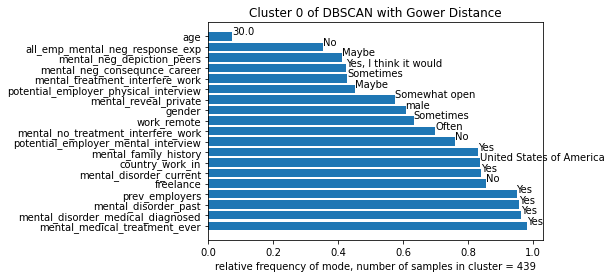

<Figure size 40000x4000 with 0 Axes>

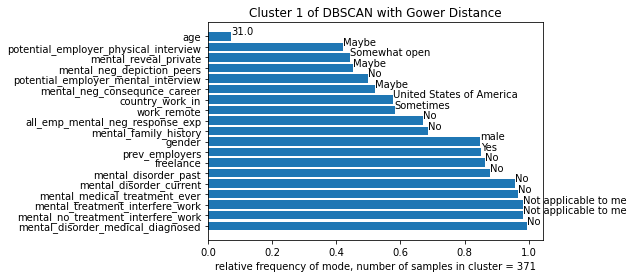

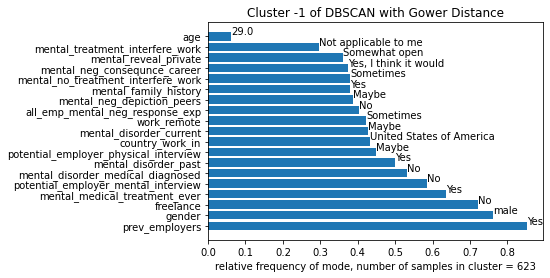

In [38]:
# plotting cluster 0 
y_pos = np.arange(len(df_visualisation_cluster_0["column"]))

plt.barh(y_pos, df_visualisation_cluster_0["relative frequency"], alpha=1)
plt.yticks(y_pos, df_visualisation_cluster_0["column"])
plt.xlabel(f'relative frequency of mode, number of samples in cluster = {len(dataframes_clustered["all_countries"][0])}')
plt.title('Cluster 0 of DBSCAN with Gower Distance')

for y, mode in zip(range(len(df_visualisation_cluster_0["column"])), df_visualisation_cluster_0["mode"]):
    plt.text(df_visualisation_cluster_0["relative frequency"][y], y, mode, va="bottom")

#plt.tight_layout()
plt.figure(dpi=400, figsize=(100, 10))  
plt.show()

# plotting cluster 1
y_pos = np.arange(len(df_visualisation_cluster_1["column"]))

plt.barh(y_pos, df_visualisation_cluster_1["relative frequency"], alpha=1)
plt.yticks(y_pos, df_visualisation_cluster_1["column"])
plt.xlabel(f'relative frequency of mode, number of samples in cluster = {len(dataframes_clustered["all_countries"][1])}')
plt.title('Cluster 1 of DBSCAN with Gower Distance')

for y, mode in zip(range(len(df_visualisation_cluster_1["column"])), df_visualisation_cluster_1["mode"]):
    plt.text(df_visualisation_cluster_1["relative frequency"][y], y, mode, va="bottom")

plt.show()

# plotting cluster -1
y_pos = np.arange(len(df_visualisation_cluster__1["column"]))

plt.barh(y_pos, df_visualisation_cluster__1["relative frequency"], alpha=1)
plt.yticks(y_pos, df_visualisation_cluster__1["column"])
plt.xlabel(f'relative frequency of mode, number of samples in cluster = {len(dataframes_clustered["all_countries"][-1])}')
plt.title('Cluster -1 of DBSCAN with Gower Distance')


for y, mode in zip(range(len(df_visualisation_cluster__1["column"])), df_visualisation_cluster__1["mode"]):
    plt.text(df_visualisation_cluster__1["relative frequency"][y], y, mode, va="bottom")

plt.show()

Trying Agglomerative Clustering to see if it performs

In [39]:
n_cluster_list = [x for x in range(2, 11, 1)]
list_method = ['complete', 'average', 'single'] #  'ward'

hierarchical_cluster_dict = {}
clusters_dict = {}
score_list = []
data_all = []
data1 = []
data2 = []  

for x in list_method:
    hierarchical_cluster_dict[x] = {}
    clusters_dict[x] = {}


for x in list_method:
    for y in n_cluster_list:
        hierarchical_cluster_dict[x][y] = AgglomerativeClustering(n_clusters=y, affinity='precomputed', linkage=x)
        clusters_dict[x][y] = hierarchical_cluster_dict[x][y].fit_predict(gower_matrix_dict["all_countries"])
        dataframes_dict["all_countries_hierarchical"]["cluster"] = hierarchical_cluster_dict[x][y].labels_ 
        
        data1.append(x)
        data1.append(y)
        score = np.nan
        try:
            score = metrics.silhouette_score(gower_matrix_dict["all_countries_hierarchical"], hierarchical_cluster_dict[x][y].labels_)
        except: ValueError
        data1.append(score)
            
            
        data2 = [data1]
        data_all.extend(data2)
        data1 = []
        date2 = []  

df_silhouette_score_hierarchical = pd.DataFrame(data_all, columns=['method', 'no. of cluster', 'score']) 
df_silhouette_score_hierarchical.sort_values(by="score", inplace=True, ascending=False)
print(df_silhouette_score_hierarchical.loc[df_silhouette_score_hierarchical['score'].idxmax()])

method            complete
no. of cluster           2
score             0.374067
Name: 0, dtype: object


In [40]:
# find the top four combinations of number of clusters and linkages

df_silhouette_score_hierarchical_eda = df_silhouette_score_hierarchical[:4]
method_list = []
cluster_list_1 = []

for x, y in zip(df_silhouette_score_hierarchical_eda["method"], df_silhouette_score_hierarchical_eda["no. of cluster"]):
    method_list.append(x)
    cluster_list_1.append(y)

In [41]:
df_silhouette_score_hierarchical_eda["option"] = [1, 2, 3, 4]

C:\Users\Max_G\AppData\Local\Temp/ipykernel_27416/2572557118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_silhouette_score_hierarchical_eda["option"] = [1, 2, 3, 4]


In [42]:
# creating a dictionary with the top four clustering optinons.

print("Creating dataframes for the following methods\n", 
df_silhouette_score_hierarchical_eda)

dataframes_dict_hierarchical = {}

options = [x for x in range(1,5,1)]

for x in options:
    dataframes_dict_hierarchical[x] = dataframes_dict["all_countries_hierarchical"].copy()

# cluster the top four methods

for x, y, z in zip(method_list, cluster_list_1, options):
    hierarchical_cluster = AgglomerativeClustering(n_clusters=y, affinity='precomputed', linkage=x)
    hierarchical_cluster.fit_predict(gower_matrix_dict["all_countries_hierarchical"])
    dataframes_dict_hierarchical[z]["cluster"] = hierarchical_cluster.labels_ 
        

Creating dataframes for the following methods
       method  no. of cluster     score  option
0   complete               2  0.374067       1
9    average               2  0.370703       2
10   average               3  0.280263       3
11   average               4  0.206299       4


Let's see how the dendogram looks.

C:\Users\Max_G\AppData\Local\Temp/ipykernel_27416/2961432765.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = dendrogram(linkage(gower_matrix_dict["all_countries_hierarchical"], method='average'))


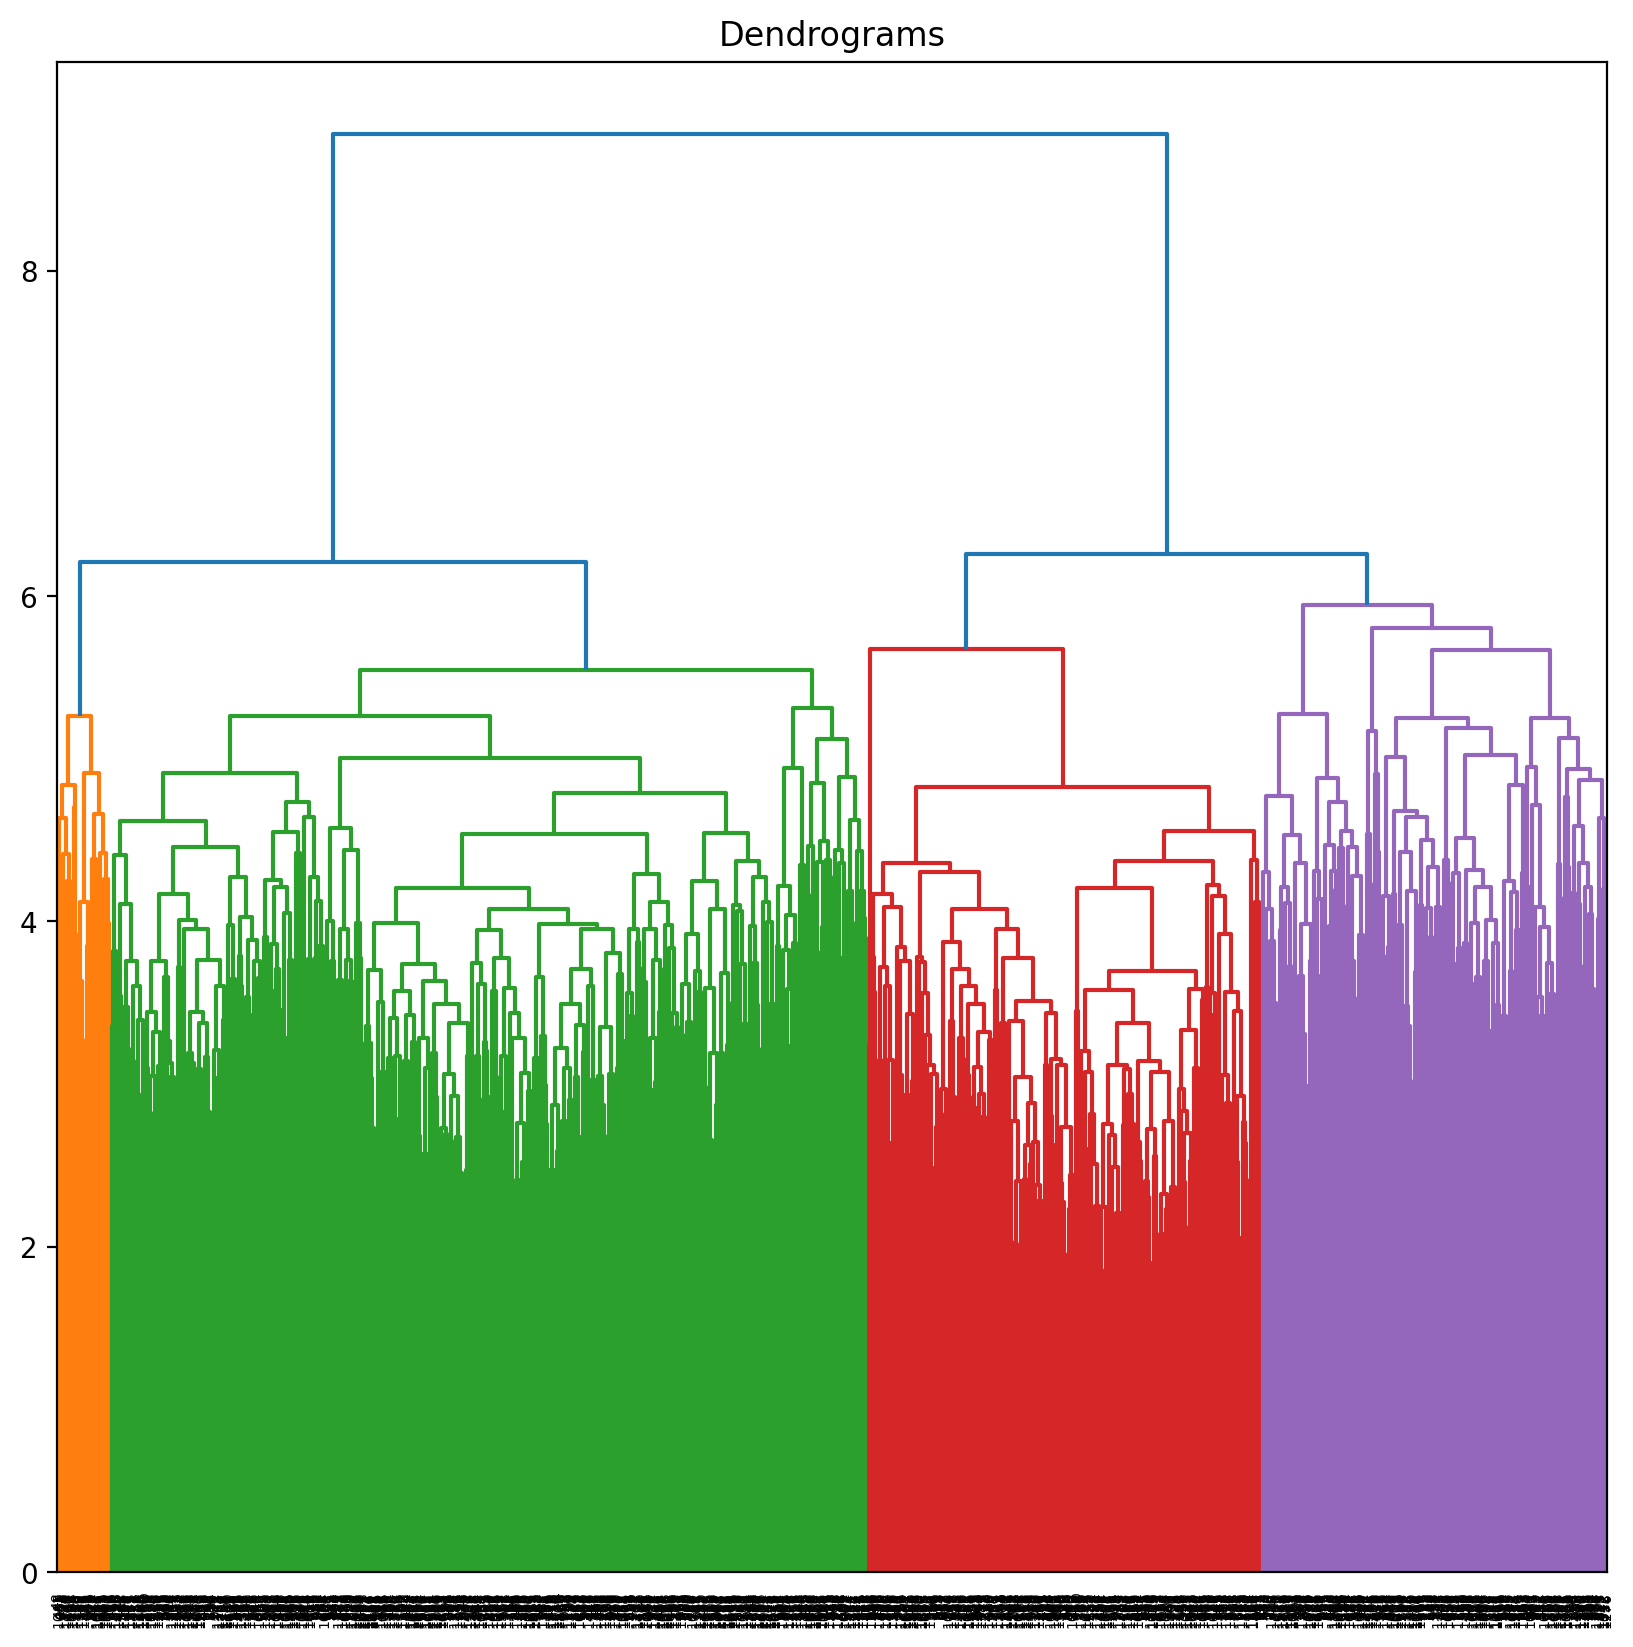

In [43]:
plt.figure(dpi=200, figsize=(10, 10))  
plt.title("Dendrograms")  
dend = dendrogram(linkage(gower_matrix_dict["all_countries_hierarchical"], method='average'))

In [44]:
cluster_list =[]

for x in dataframes_dict_hierarchical:
    sub_list =[]
    for y in dataframes_dict_hierarchical[x]["cluster"].unique():
        sub_list.append(y)
    cluster_list.extend([sub_list])    

# creating a dictionary of the corresponding cluster lists.
cluster_list_dict = {}
for list1, df_name, in zip(cluster_list, dataframes_dict_hierarchical):
    cluster_list_dict[df_name]= list1

# creating a sub-dictionary of clustered dataframes.
dataframes_dict_hierarchical_clustered = {}
for df_name, list1 in zip(dataframes_dict_hierarchical, cluster_list):
    dataframes_dict_hierarchical_clustered[df_name] = {}
    
    for list1 in cluster_list:
        for number in list1:
            dataframes_dict_hierarchical_clustered[df_name][number] = dataframes_dict_hierarchical[df_name].loc[dataframes_dict_hierarchical[df_name]["cluster"] == number]
            if len(dataframes_dict_hierarchical_clustered[df_name][number]) == 0:
                del dataframes_dict_hierarchical_clustered[df_name][number]

In [45]:
#creating a dictionary containing the analysed results of the clusterings.


pd.set_option("display.max_rows", 50, "display.max_columns", 50)

df_hierarchical_clustered_analysis = {}

for option in dataframes_dict_hierarchical_clustered:
    df_hierarchical_clustered_analysis[option] = {}
    for cluster in dataframes_dict_hierarchical_clustered[option]:
        data1 = []
        data2 = []
        data_all = []
        for column in dataframes_dict_hierarchical_clustered[option][cluster]:
            data1.append(column)
            data1.append(dataframes_dict_hierarchical_clustered[option][cluster][column].mode().to_list()[0])
            data1.append(dataframes_dict_hierarchical_clustered[option][cluster][column].value_counts().to_list()[0]/len(dataframes_dict_hierarchical_clustered[option][cluster]))
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            date2 = []
    
        df_hierarchical_clustered_analysis[option][cluster] = pd.DataFrame(data_all, columns=['column', 'mode', 'relative frequency'])
        df_hierarchical_clustered_analysis[option][cluster].sort_values(by=['relative frequency'], inplace=True, ascending=False)




In [46]:
df_visualisation_hierachical = {}

for option in df_hierarchical_clustered_analysis:
    df_visualisation_hierachical[option] = {}
    for cluster in df_hierarchical_clustered_analysis[option]:
        df_visualisation_hierachical[option][cluster] = df_hierarchical_clustered_analysis[option][cluster].drop(df_hierarchical_clustered_analysis[option][cluster][df_hierarchical_clustered_analysis[option][cluster].column == "cluster"].index)
        df_visualisation_hierachical[option][cluster] = df_visualisation_hierachical[option][cluster].reset_index().drop(columns="index", axis = 1)

      method  no. of cluster     score  option
0   complete               2  0.374067       1
9    average               2  0.370703       2
10   average               3  0.280263       3
11   average               4  0.206299       4


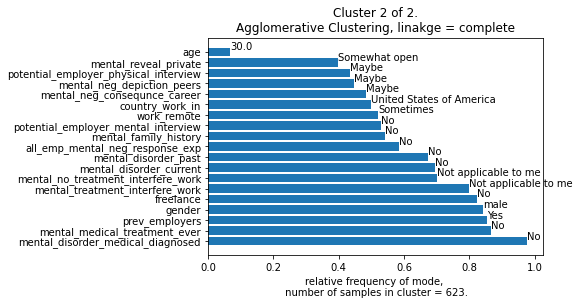

<Figure size 40000x4000 with 0 Axes>

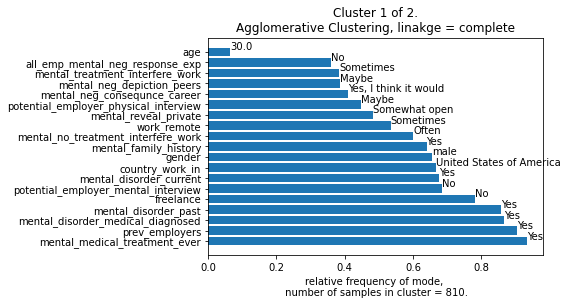

<Figure size 40000x4000 with 0 Axes>

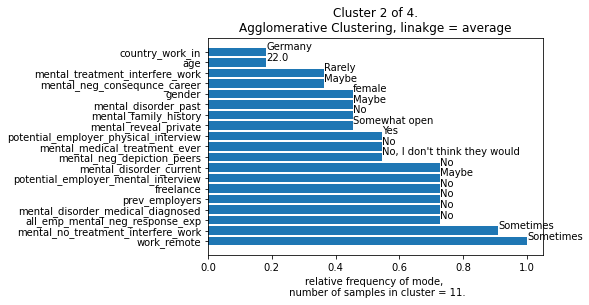

<Figure size 40000x4000 with 0 Axes>

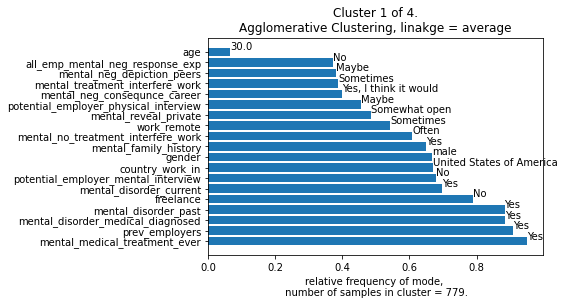

<Figure size 40000x4000 with 0 Axes>

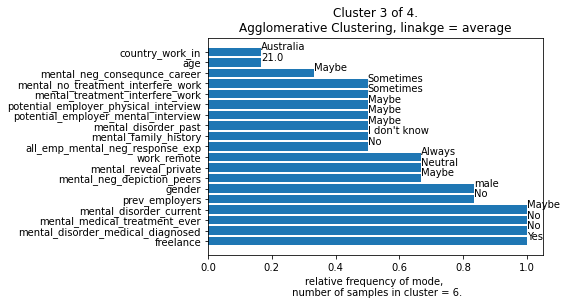

<Figure size 40000x4000 with 0 Axes>

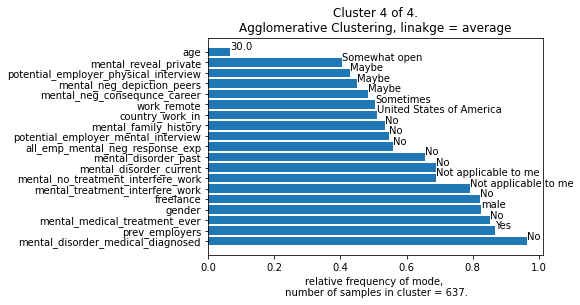

<Figure size 40000x4000 with 0 Axes>

In [47]:
# hence the dendogram implied two or four clusters I am going with those options. 
# option 1 and 4 of the df_silhouette_score_hierarchical_eda dictionary contain those clusters combined with the optimal 
# linkage for the highest silhouete score.

df_x_label_text = df_silhouette_score_hierarchical_eda[(df_silhouette_score_hierarchical_eda['option'] == 1) | (df_silhouette_score_hierarchical_eda['option'] == 4)]
print(df_silhouette_score_hierarchical_eda)


for option in df_x_label_text["option"]:
    for cluster in df_visualisation_hierachical[option]:
        df_visualisation_hierachical[option][cluster]
        
        y_pos = np.arange(len(df_visualisation_hierachical[option][cluster]["column"]))

        plt.barh(y_pos, df_visualisation_hierachical[option][cluster]["relative frequency"], alpha=1)
        plt.yticks(y_pos, df_visualisation_hierachical[option][cluster]["column"])
        plt.xlabel(f"relative frequency of mode, \n number of samples in cluster = \
{len(dataframes_dict_hierarchical_clustered[option][cluster])}.")
        plt.title(f"Cluster {cluster+1} of {df_x_label_text.loc[df_x_label_text['option'] == option, 'no. of cluster'].iloc[0]}.\n\
Agglomerative Clustering, linakge = {df_x_label_text.loc[df_x_label_text['option'] == option, 'method'].iloc[0]}")
        for y, mode in zip(range(len(df_visualisation_hierachical[option][cluster]["column"])), df_visualisation_hierachical[option][cluster]["mode"]):
            plt.text(df_visualisation_hierachical[option][cluster]["relative frequency"][y], y, mode, va="bottom")

#plt.tight_layout()
        plt.figure(dpi=400, figsize=(100, 10))  
        plt.show()


Doing a PCA on the OHE data, to see if it yields better results than the gower approach.

In [48]:
# scaling the only numerical feature wihtin the data.
list_of_ohe_df = ["df_ohe_w/o_bow_features", "df_ohe_with_bow_features"]

for x in list_of_ohe_df:
    df_ohe_pca_dict[x]["age"] = StandardScaler().fit_transform(dataframes_dict[x]["age"].array.reshape(-1, 1))

Doing the PCA

In [49]:
# Loop Function to identify number of principal components that explain at least 85% of the variance
pca_df = {}

for x in df_ohe_pca_dict:

    for comp in range(3, df_ohe_pca_dict[x].shape[1]):
        pca = PCA(n_components= comp, random_state=42)
        pca.fit(df_ohe_pca_dict[x])
        comp_check = pca.explained_variance_ratio_
        final_comp = comp
        if comp_check.sum() > 0.85:
            break
        
    Final_PCA = PCA(n_components= final_comp,random_state=42)
    Final_PCA.fit(df_ohe_pca_dict[x])
    pca_df[x]=Final_PCA.transform(df_ohe_pca_dict[x])
    num_comps = comp_check.shape[0]
    print(f"Using {final_comp} components, we can explain {comp_check.sum()}% of the variability in the original data of df {x}")


# see https://towardsdatascience.com/one-hot-encoding-standardization-pca-data-preparation-steps-for-segmentation-in-python-24d07671cf0b


print("That is not a great result. Basically the OHE created more features even after PCA, than the original dataset had " \
"even after dropping the country_live_in column, which had one of the highest cardinalities.")

Using 25 components, we can explain 0.8549224938369955% of the variability in the original data of df df_ohe_w/o_bow_features
Using 33 components, we can explain 0.8555561253028016% of the variability in the original data of df df_ohe_with_bow_features
That is not a great result. Basically the OHE created more features even after PCA, than the original dataset had even after dropping the country_live_in column, which had one of the highest cardinalities.


In [50]:
pca_applied_dict_df = {}
for x in pca_df:
    pca_applied_dict_df[x]=pd.DataFrame(pca_df[x])


In [51]:
# # calculation a correlation matrix.

# feature_names = df_ohe_pca.columns.to_list()

# # calculate the correlation matrix and
# # create a correlation graph
# fig, cor_mat = plot_pca_correlation_graph(df_ohe_pca, \
#     feature_names, dimensions=(1, 22), \
#     figure_axis_size=10)
# plt.show()

Again, finding the best eps and min_sample scores with DBSCAN

In [52]:
for x in pca_applied_dict_df:
    pca_applied_dict_df[x].columns = pca_applied_dict_df[x].columns.map(str) 



eps_list = []
for i in np.linspace(2.0, 4.0, num=21):
    eps_list.append(i.round(2))

min_sampe_list = [x for x in range(40, 80 , 2)]


data_all = []

for df_name in pca_applied_dict_df:
    for eps_value in eps_list:
        data1 = []
        data2 = []
        for min_sample in min_sampe_list:
            dbscan_cluster = DBSCAN(eps=eps_value, 
                            min_samples=min_sample, 
                            metric="euclidean")

            dbscan_cluster.fit(pca_applied_dict_df[x])
    
            pca_applied_dict_df[df_name]["cluster"] = dbscan_cluster.labels_
            no_of_clusters = pca_applied_dict_df[df_name]["cluster"].nunique()
    
            data1.append(df_name)
            data1.append(eps_value)
            data1.append(min_sample)
            score = np.nan
            try:
                score = metrics.silhouette_score(pca_applied_dict_df[df_name], dbscan_cluster.labels_)
            except: ValueError
            data1.append(no_of_clusters)
            data1.append(score)
            
            
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            

df_silhouette_score_pca = pd.DataFrame(data_all, columns=["df_name", 'eps_value', 'min_sample', '# of clusters', 'score']) 

df_silhouette_score_pca  = df_silhouette_score_pca[df_silhouette_score_pca['score'].notna()]
df_silhouette_score_pca = df_silhouette_score_pca.loc[df_silhouette_score_pca['# of clusters'] > 2]

for x in pca_applied_dict_df:
    pca_applied_dict_df[x].drop(columns= "cluster", inplace=True)

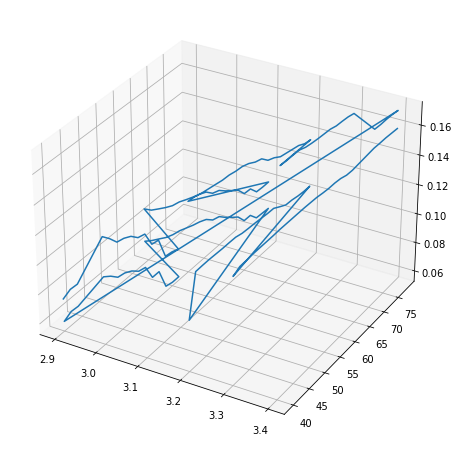

In [53]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

x=df_silhouette_score_pca["eps_value"]
y=df_silhouette_score_pca["min_sample"]
z=df_silhouette_score_pca["score"]

ax.plot(x,y,z)

plt.show()


In [54]:
# creating a dictionary for all the silhouette_score dataframes by name of the coresponding dataframe.
df_silhouette_score_clustered_pca = {}

for df_name in pca_applied_dict_df:
    df_silhouette_score_clustered_pca[df_name] = df_silhouette_score_pca.loc[df_silhouette_score_pca['df_name'] == df_name] 

In [55]:
#creating a dictionary conatining all the optimal values, so that dbscan can use them.

best_parameters_dict_pca = {}

for x in df_silhouette_score_clustered_pca:
    best_parameters_dict_pca[x] = {}

for x in df_silhouette_score_clustered_pca:
    best_parameters_dict_pca[x]["best_eps_value"] = df_silhouette_score_clustered_pca[x].loc[df_silhouette_score_clustered_pca[x]['score'].idxmax()][1]
    best_parameters_dict_pca[x]["best_min_sample"] = df_silhouette_score_clustered_pca[x].loc[df_silhouette_score_clustered_pca[x]['score'].idxmax()][2]
    best_parameters_dict_pca[x]["no_of_clusters"] = df_silhouette_score_clustered_pca[x].loc[df_silhouette_score_clustered_pca[x]['score'].idxmax()][3]
    best_parameters_dict_pca[x]["silhouette_score"] = df_silhouette_score_clustered_pca[x].loc[df_silhouette_score_clustered_pca[x]['score'].idxmax()][4]


for x in df_silhouette_score_clustered_pca:
    print(f"The dataframe {x}, has the following values")
    print("best_eps_value =", best_parameters_dict_pca[x]["best_eps_value"])
    print("best_min_sample =",  best_parameters_dict_pca[x]["best_min_sample"])
    print("no_of_clusters =", best_parameters_dict_pca[x]["no_of_clusters"])
    print("silhouette_score =", best_parameters_dict_pca[x]["silhouette_score"])

The dataframe df_ohe_w/o_bow_features, has the following values
best_eps_value = 3.4
best_min_sample = 70
no_of_clusters = 3
silhouette_score = 0.1730366428969301
The dataframe df_ohe_with_bow_features, has the following values
best_eps_value = 3.4
best_min_sample = 70
no_of_clusters = 3
silhouette_score = 0.16072808652425705


In [56]:
# the actual clustering for all the dataframes with the optimal values.

dbscan_cluster_dict_best_fit_pca = {}

for x in best_parameters_dict_pca:
    dbscan_cluster_dict_best_fit_pca[x] = DBSCAN(eps=best_parameters_dict_pca[x]["best_eps_value"], 
                            min_samples=best_parameters_dict_pca[x]["best_min_sample"], 
                            metric="euclidean")
        

for x in dbscan_cluster_dict_best_fit_pca:
    
    dbscan_cluster_dict_best_fit_pca[x].fit(pca_applied_dict_df[x])
    pca_applied_dict_df[x]["cluster"] = dbscan_cluster_dict_best_fit_pca[x].labels_
    print(x, metrics.silhouette_score(pca_applied_dict_df[x], dbscan_cluster_dict_best_fit_pca[x].labels_))
    




df_ohe_w/o_bow_features 0.2155317387234517
df_ohe_with_bow_features 0.16376987589341466


Preparing a dictionary for EDA.

In [57]:
cluster_list_pca = []
dataframes_dict_pca = {}

dataframes_dict_pca["df_ohe_with_bow_features"] = pd.concat((df_ohe_prepare_for_reverse, pca_applied_dict_df["df_ohe_with_bow_features"]["cluster"]), axis =1)
dataframes_dict_pca["df_ohe_w/o_bow_features"] = pd.concat((df_ohe_prepare_for_reverse, pca_applied_dict_df["df_ohe_w/o_bow_features"]["cluster"]), axis=1)


# creating a list of the cluster lists.
for x in dataframes_dict_pca:
    sub_list_pca =[]
    for y in dataframes_dict_pca[x]["cluster"].unique():
        
        sub_list_pca.append(y)
        
    cluster_list_pca.extend([sub_list_pca])    

# creating a dictionary of the corresponding cluster lists.
cluster_list_dict_pca = {}
for list, df_name, in zip(cluster_list_pca, dataframes_dict_pca):
    cluster_list_dict_pca[df_name] = list

# creating a sub-dictionary of clustered dataframes.
dataframes_clustered_pca = {}
for df_name, list in zip(dataframes_dict_pca, cluster_list_pca):
    dataframes_clustered_pca[df_name] = {}
    
    for list in cluster_list_pca:
        for number in list:
            dataframes_clustered_pca[df_name][number] = dataframes_dict_pca[df_name].loc[dataframes_dict_pca[df_name]["cluster"] == number]
            if len(dataframes_clustered_pca[df_name][number]) == 0:
                del dataframes_clustered_pca[df_name][number]

  


In [58]:
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

df_clustered_analysis_pca = {}

for df_name in dataframes_clustered_pca:
    df_clustered_analysis_pca[df_name] = {}
    for cluster in dataframes_clustered_pca[df_name]:
        data1 = []
        data2 = []
        data_all = []
        for column in dataframes_clustered_pca[df_name][cluster]:
            data1.append(column)
            data1.append(dataframes_clustered_pca[df_name][cluster][column].mode().to_list()[0])
            data1.append(dataframes_clustered_pca[df_name][cluster][column].value_counts().to_list()[0]/len(dataframes_clustered_pca[df_name][cluster]))
            data2 = [data1]
            data_all.extend(data2)
            data1 = []
            data2 = []
    
        df_clustered_analysis_pca[df_name][cluster] = pd.DataFrame(data_all, columns=['column', 'mode', 'relative frequency'])
        df_clustered_analysis_pca[df_name][cluster].sort_values(by=['relative frequency'], inplace=True, ascending=False)

In [59]:
df_visualisation_pca = {}

for df_name in df_clustered_analysis_pca:
    df_visualisation_pca[df_name] = {}
    for cluster in df_clustered_analysis_pca[df_name]:
        df_visualisation_pca[df_name][cluster] = df_clustered_analysis_pca[df_name][cluster].drop(df_clustered_analysis_pca[df_name][cluster][df_clustered_analysis_pca[df_name][cluster].column == "cluster"].index)
        df_visualisation_pca[df_name][cluster] = df_visualisation_pca[df_name][cluster].reset_index().drop(columns="index", axis = 1)

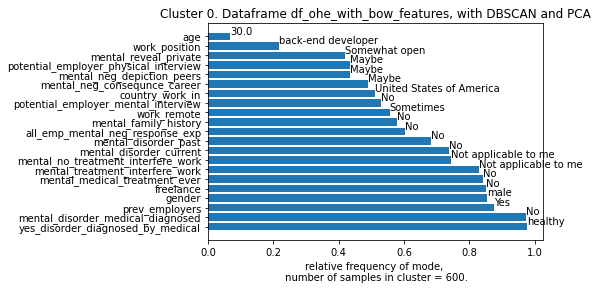

<Figure size 40000x4000 with 0 Axes>

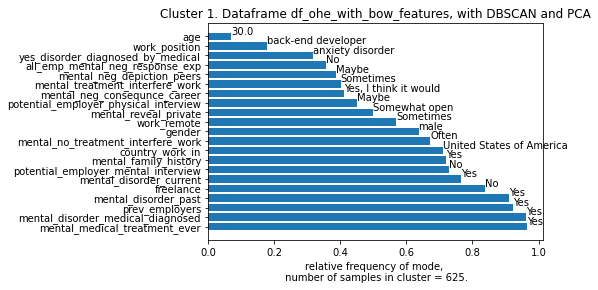

<Figure size 40000x4000 with 0 Axes>

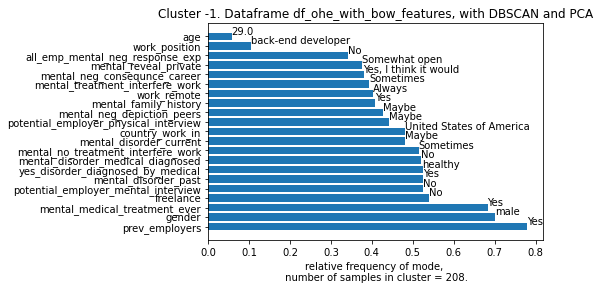

<Figure size 40000x4000 with 0 Axes>

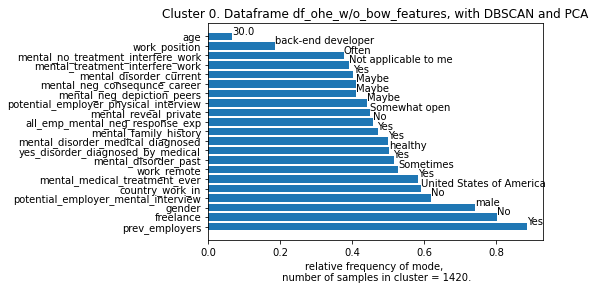

<Figure size 40000x4000 with 0 Axes>

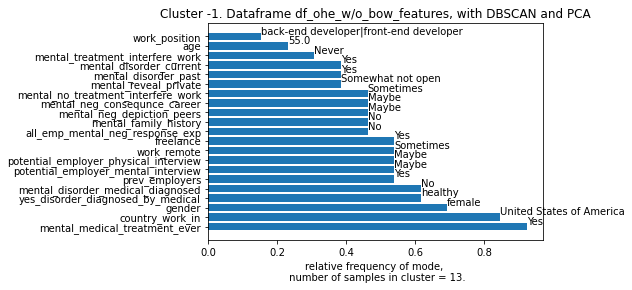

<Figure size 40000x4000 with 0 Axes>

In [60]:
# Preparation of the visualisation dictionary


for option in df_visualisation_pca:
    for cluster in df_visualisation_pca[option]:
        y_pos = np.arange(len(df_visualisation_pca[option][cluster]["column"]))

        plt.barh(y_pos, df_visualisation_pca[option][cluster]["relative frequency"], alpha=1)
        plt.yticks(y_pos, df_visualisation_pca[option][cluster]["column"])
        plt.xlabel(f"relative frequency of mode, \n number of samples in cluster = \
{len(dataframes_clustered_pca[option][cluster])}.")
        plt.title(f'Cluster {cluster}. Dataframe {option}, with DBSCAN and PCA')
        for y, mode in zip(range(len(df_visualisation_pca[option][cluster]["column"])), df_visualisation_pca[option][cluster]["mode"]):
            plt.text(df_visualisation_pca[option][cluster]["relative frequency"][y], y, mode, va="bottom")

#plt.tight_layout()
        plt.figure(dpi=400, figsize=(100, 10))  
        plt.show()

#it's done